<h1 align="center">Rainfall Predict with LSTM and LSTM Attention </h1>



In [1]:
!pip install -U scikit-learn

Import the library needed

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Attention, Add, Concatenate, Input, Layer
from tensorflow.keras.models import Model, load_model
import matplotlib
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import sklearn
import seaborn as sns
import joblib

In [3]:
print("Pandas version:", pd.__version__)
print("NumPy version:", np.__version__)
print("Scikit-learn version:", sklearn.__version__)
print("TensorFlow version:", tf.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", sns.__version__)

Pandas version: 2.2.2
NumPy version: 1.26.4
Scikit-learn version: 1.5.0
TensorFlow version: 2.16.1
Matplotlib version: 3.8.4
Seaborn version: 0.13.2


Read data

In [4]:
# Membaca data keseluruhan

#Skenario 1
# rainfall_data_url = "https://raw.githubusercontent.com/arifian853/rainfall-predict-lstm-attention/master/dataset/filled/scenario3/final/final-data-2019-2023.csv"

# Skenario 2
rainfall_data_url = "https://raw.githubusercontent.com/arifian853/rainfall-predict-lstm-attention/master/dataset/filled/scenario3/final/final-data-2014-2024.csv"

# Skenario 3
#rainfall_data_url = "https://raw.githubusercontent.com/arifian853/rainfall-predict-lstm-attention/master/dataset/filled/scenario3/final/final-data-2010-2024.csv"

df = pd.read_csv(rainfall_data_url, parse_dates=['Tanggal'], index_col='Tanggal')

print('Dataset : \n', df.head())
print('Dataset : \n', df.tail())
print('\n')

# Menghitung jumlah hari dalam dataset
days_count = len(df.index)
print("Jumlah hari dalam dataset:", days_count)




Dataset : 
               Tn    Tx  Tavg  RH_avg   RR   ss  ff_x  ddd_x  ff_avg ddd_car
Tanggal                                                                    
01/01/2014  24.0  29.2  26.9    84.0  0.0  2.8   7.0   30.0     4.0      N 
02/01/2014  23.6  30.7  27.1    84.0  0.0  0.0  10.0   40.0     5.0      NE
03/01/2014  25.1  29.4  26.4    88.0  0.0  0.0   8.0   40.0     3.0      NE
04/01/2014  24.8  30.6  27.0    82.0  0.0  0.0   8.0   50.0     3.0      N 
05/01/2014  22.4  27.6  24.8    93.0  6.3  0.7   5.0  350.0     3.0      N 
Dataset : 
               Tn    Tx  Tavg  RH_avg    RR   ss  ff_x  ddd_x  ff_avg ddd_car
Tanggal                                                                     
27/05/2024  26.6  33.4  29.7    82.0   0.0  1.8   5.0  140.0     2.0      S 
28/05/2024  27.7  33.4  29.0    87.0   0.0  2.7   5.0  170.0     2.0      S 
29/05/2024  25.7  34.0  29.3    83.0  20.6  2.8   5.0  200.0     2.0      C 
30/05/2024  26.9  31.2  28.3    85.0  20.6  6.1   7.0  210.

Correlation matrix


 Correlation Matrix 



<Axes: >

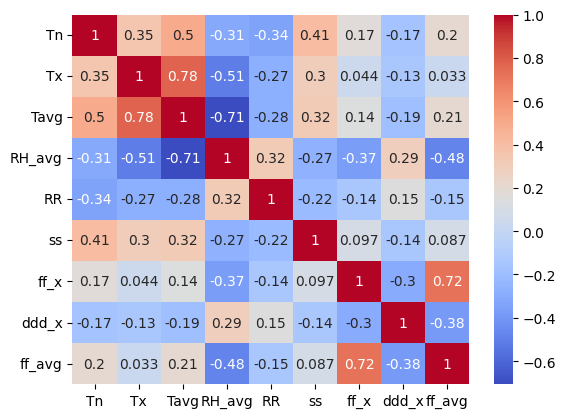

In [5]:
print("\n Correlation Matrix \n")

matrix = df.drop(columns=['ddd_car']).corr()
# matrix = df.corr()
#plotting correlation matrix
sns.heatmap(matrix, cmap="coolwarm", annot=True)


Split data to train, test, and validate

In [6]:
# Membagi data menjadi training, validation, dan testing sets

# Scenario 1 - 70:15:15
# train = df['01-01-2019':'28-02-2022']
# validation = df['01-03-2022':'28-02-2023']
# test = df['01-03-2023':'31-12-2023']

# Scenario 2 - 70:15:15
train = df['01/01/2014':'15/04/2021']
validation = df['16/04/2021':'06/11/2022']
test = df['07/11/2022':'31/05/2024']

# Scenario 3 - 80:10:10
# train = df['01-01-2010': '13-07-2021']
# validation = df['14-07-2021' : '21-12-2022']
# test = df['22-12-2022' : '31-05-2024']

# Displaying the number of records in each set
print(f'Training set: {train.shape[0]} records')
print(f'Validation set: {validation.shape[0]} records')
print(f'Test set: {test.shape[0]} records')

# Selecting features and target
features = ['Tavg', 'RH_avg', 'ss', 'ff_avg']
X_train = train[features]
y_train = train['RR']
X_val = validation[features]
y_val = validation['RR']
X_test = test[features]
y_test = test['RR']

Training set: 2662 records
Validation set: 570 records
Test set: 572 records


In [8]:
# Normalisasi data Fitur dan target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Reshape y_train, y_val, y_test to (n_samples, 1)
y_train_reshaped = y_train.values.reshape(-1, 1)
y_val_reshaped = y_val.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)

# Fit and transform on training set, transform on validation and test sets
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train_reshaped).flatten()
y_val_scaled = scaler_y.transform(y_val_reshaped).flatten()
y_test_scaled = scaler_y.transform(y_test_reshaped).flatten()

# Fungsi untuk membentuk data menjadi sequence
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 10  # Misalnya, gunakan 10 hari sebelumnya untuk memprediksi hari berikutnya
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, time_steps)

# Save the scalers
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')

Scaled X_train: 
 [[0.53333333 0.54545455 0.24561404 0.5       ]
 [0.56       0.54545455 0.         0.625     ]
 [0.46666667 0.66666667 0.         0.375     ]
 ...
 [0.74666667 0.36363636 0.70175439 0.25      ]
 [0.65333333 0.42424242 0.6754386  0.125     ]
 [0.4        0.84848485 0.64912281 0.125     ]]
Scaled X_val: 
 [[0.64       0.51515152 0.33333333 0.125     ]
 [0.25333333 0.96969697 0.07017544 0.25      ]
 [0.65333333 0.48484848 0.28070175 0.25      ]
 ...
 [0.66666667 0.63636364 0.13157895 0.25      ]
 [0.2        0.87878788 0.22807018 0.125     ]
 [0.42666667 0.78787879 0.         0.25      ]]
Scaled X_test: 
 [[0.53333333 0.57575758 0.         0.25      ]
 [0.52       0.72727273 0.21052632 0.25      ]
 [0.36       0.75757576 0.42982456 0.25      ]
 ...
 [0.85333333 0.51515152 0.24561404 0.25      ]
 [0.72       0.57575758 0.53508772 0.25      ]
 [0.70666667 0.60606061 0.53508772 0.25      ]]
Scaled y_train: 
 [0.  0.  0.  ... 0.1 0.5 0. ]
Scaled y_val: 
 [0.  0.  0.  ... 0.1 

['scaler_y.pkl']

Data shape verification

In [9]:
# Verifikasi bentuk data
print("Shape of X_train_seq:", X_train_seq.shape)
print("Shape of y_train_seq:", y_train_seq.shape)
print("Shape of X_val_seq:", X_val_seq.shape)
print("Shape of y_val_seq:", y_val_seq.shape)
print("Shape of X_test_seq:", X_test_seq.shape)
print("Shape of y_test_seq:", y_test_seq.shape)

Shape of X_train_seq: (2652, 10, 4)
Shape of y_train_seq: (2652,)
Shape of X_val_seq: (560, 10, 4)
Shape of y_val_seq: (560,)
Shape of X_test_seq: (562, 10, 4)
Shape of y_test_seq: (562,)


### Regular LSTM model build and training

In [10]:
# Membangun model LSTM biasa
def build_lstm_model(input_shape, units=64, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units, activation='tanh', input_shape=input_shape, return_sequences=True))
    model.add(LSTM(units, activation='tanh', input_shape=input_shape, return_sequences=True))
    model.add(LSTM(units, activation='tanh', input_shape=input_shape))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Membangun model LSTM
input_shape = (time_steps, X_train_seq.shape[2])
model_lstm = build_lstm_model(input_shape)

# Displaying model summary
model_lstm.summary()

history_lstm = model_lstm.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, verbose=2, validation_data=(X_val_seq, y_val_seq))

# Evaluasi model LSTM
y_pred_lstm = model_lstm.predict(X_test_seq)

def mean_squared_error(y_true, y_pred):
    n = len(y_true)
    mse = sum((y_true[i] - y_pred[i]) ** 2 for i in range(n)) / n
    return mse

def mean_absolute_error(y_true, y_pred):
    n = len(y_true)
    mae = sum(abs(y_true[i] - y_pred[i]) for i in range(n)) / n
    return mae

def root_mean_squared_error(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    return rmse

def r2_score(y_true, y_pred):
    mean_y_true = sum(y_true) / len(y_true)
    ss_tot = sum((y - mean_y_true) ** 2 for y in y_true)
    ss_res = sum((y_true[i] - y_pred[i]) ** 2 for i in range(len(y_true)))
    r2 = 1 - (ss_res / ss_tot)
    return r2

mse_lstm = mean_squared_error(y_test_seq, y_pred_lstm)
mae_lstm = mean_absolute_error(y_test_seq, y_pred_lstm)
rmse_lstm = root_mean_squared_error(y_test_seq, y_pred_lstm)
r2_lstm = r2_score(y_test_seq, y_pred_lstm)

print(" \n ===================================================== \n")
print(f'R-squared LSTM: {r2_lstm}')
print(f'MSE LSTM: {mse_lstm}')
print(f'MAE LSTM: {mae_lstm}')
print(f'RMSE LSTM: {rmse_lstm}')
print(" \n ===================================================== \n")


c:\Users\arifi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,777 (327.25 KB)

 Trainable params: 83,777 (327.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
83/83 - 7s - 85ms/step - loss: 0.0065 - val_loss: 0.0070
Epoch 2/50
83/83 - 1s - 12ms/step - loss: 0.0063 - val_loss: 0.0064
Epoch 3/50
83/83 - 1s - 18ms/step - loss: 0.0062 - val_loss: 0.0063
Epoch 4/50
83/83 - 1s - 10ms/step - loss: 0.0061 - val_loss: 0.0061
Epoch 5/50
83/83 - 1s - 9ms/step - loss: 0.0060 - val_loss: 0.0061
Epoch 6/50
83/83 - 1s - 16ms/step - loss: 0.0059 - val_loss: 0.0059
Epoch 7/50
83/83 - 1s - 13ms/step - loss: 0.0056 - val_loss: 0.0055
Epoch 8/50
83/83 - 1s - 12ms/step - loss: 0.0055 - val_loss: 0.0055
Epoch 9/50
83/83 - 1s - 10ms/step - loss: 0.0054 - val_loss: 0.0054
Epoch 10/50
83/83 - 1s - 9ms/step - loss: 0.0054 - val_loss: 0.0055
Epoch 11/50
83/83 - 1s - 10ms/step - loss: 0.0054 - val_loss: 0.0056
Epoch 12/50
83/83 - 1s - 9ms/step - loss: 0.0054 - val_loss: 0.0055
Epoch 13/50
83/83 - 1s - 9ms/step - loss: 0.0054 - val_loss: 0.0055
Epoch 14/50
83/83 - 1s - 8ms/step - loss: 0.0054 - val_loss: 0.0056
Epoch 15/50
83/83 - 1s - 12ms/step - loss: 0.005

### 1 LSTM Attention Mechanism model build and training

In [11]:
def build_lstm_attention_model(input_shape, lstm_units=64, learning_rate=0.001):
    inputs = Input(shape=input_shape)

    # Adding multiple LSTM layers sequentially
    lstm_out = LSTM(lstm_units, return_sequences=True)(inputs)
    lstm_out = LSTM(lstm_units, return_sequences=True)(lstm_out)
    lstm_out = LSTM(lstm_units, return_sequences=True)(lstm_out)

    # Attention mechanism
    attention = Attention()([lstm_out, lstm_out])
    context_vector = Add()([lstm_out, attention])

    context_vector = LSTM(lstm_units, activation='tanh')(context_vector)
    context_vector = (context_vector)
    # Output Layer
    outputs = Dense(1)(context_vector)

    # Model compilation
    model = Model(inputs, outputs)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')

    return model

# Membangun model LSTM dengan Attention Mechanism
input_shape = (time_steps, X_train_seq.shape[2])
model_lstm_attention = build_lstm_attention_model(input_shape)

# Displaying model summary
model_lstm_attention.summary()

history_lstm_attention = model_lstm_attention.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32 ,verbose=2, validation_data=(X_val_seq, y_val_seq))

# Evaluasi model LSTM dengan Attention Mechanism
y_pred_lstm_attention = model_lstm_attention.predict(X_test_seq)

def mean_squared_error(y_true, y_pred):
    n = len(y_true)
    mse = sum((y_true[i] - y_pred[i]) ** 2 for i in range(n)) / n
    return mse

def mean_absolute_error(y_true, y_pred):
    n = len(y_true)
    mae = sum(abs(y_true[i] - y_pred[i]) for i in range(n)) / n
    return mae

def root_mean_squared_error(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    return rmse

def r2_score(y_true, y_pred):
    mean_y_true = sum(y_true) / len(y_true)
    ss_tot = sum((y - mean_y_true) ** 2 for y in y_true)
    ss_res = sum((y_true[i] - y_pred[i]) ** 2 for i in range(len(y_true)))
    r2 = 1 - (ss_res / ss_tot)
    return r2

mse_lstm_attention = mean_squared_error(y_test_seq, y_pred_lstm_attention)
mae_lstm_attention = mean_absolute_error(y_test_seq, y_pred_lstm_attention)
rmse_lstm_attention = root_mean_squared_error(y_test_seq, y_pred_lstm_attention)
r2_lstm_attention = r2_score(y_test_seq, y_pred_lstm_attention)

print(" \n ===================================================== \n")
print(f'R-squared LSTM with Attention: {r2_lstm_attention}')
print(f'MSE LSTM with Attention: {mse_lstm_attention}')
print(f'MAE LSTM with Attention: {mae_lstm_attention}')
print(f'RMSE LSTM with Attention: {rmse_lstm_attention}')
print(" \n ===================================================== \n")

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 10, 64)    │     17,664 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 10, 64)    │     33,024 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 10, 64)    │     33,024 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 10, 64)    │          0 │ lstm_5[0][0],     │
│ (Attention)         │                   │            │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 10, 64)    │          0 │ lstm_5[0][0],     │
│                     │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 64)        │     33,024 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ lstm_6[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 116,801 (456.25 KB)

 Trainable params: 116,801 (456.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
83/83 - 5s - 66ms/step - loss: 0.0064 - val_loss: 0.0064
Epoch 2/50
83/83 - 1s - 10ms/step - loss: 0.0063 - val_loss: 0.0064
Epoch 3/50
83/83 - 1s - 10ms/step - loss: 0.0063 - val_loss: 0.0063
Epoch 4/50
83/83 - 1s - 10ms/step - loss: 0.0064 - val_loss: 0.0063
Epoch 5/50
83/83 - 1s - 10ms/step - loss: 0.0063 - val_loss: 0.0065
Epoch 6/50
83/83 - 1s - 10ms/step - loss: 0.0062 - val_loss: 0.0064
Epoch 7/50
83/83 - 1s - 10ms/step - loss: 0.0062 - val_loss: 0.0063
Epoch 8/50
83/83 - 1s - 10ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 9/50
83/83 - 1s - 9ms/step - loss: 0.0059 - val_loss: 0.0059
Epoch 10/50
83/83 - 1s - 9ms/step - loss: 0.0056 - val_loss: 0.0057
Epoch 11/50
83/83 - 1s - 9ms/step - loss: 0.0055 - val_loss: 0.0055
Epoch 12/50
83/83 - 1s - 9ms/step - loss: 0.0055 - val_loss: 0.0056
Epoch 13/50
83/83 - 1s - 9ms/step - loss: 0.0054 - val_loss: 0.0055
Epoch 14/50
83/83 - 1s - 9ms/step - loss: 0.0053 - val_loss: 0.0055
Epoch 15/50
83/83 - 1s - 10ms/step - loss: 0.0053

Result and evaluation

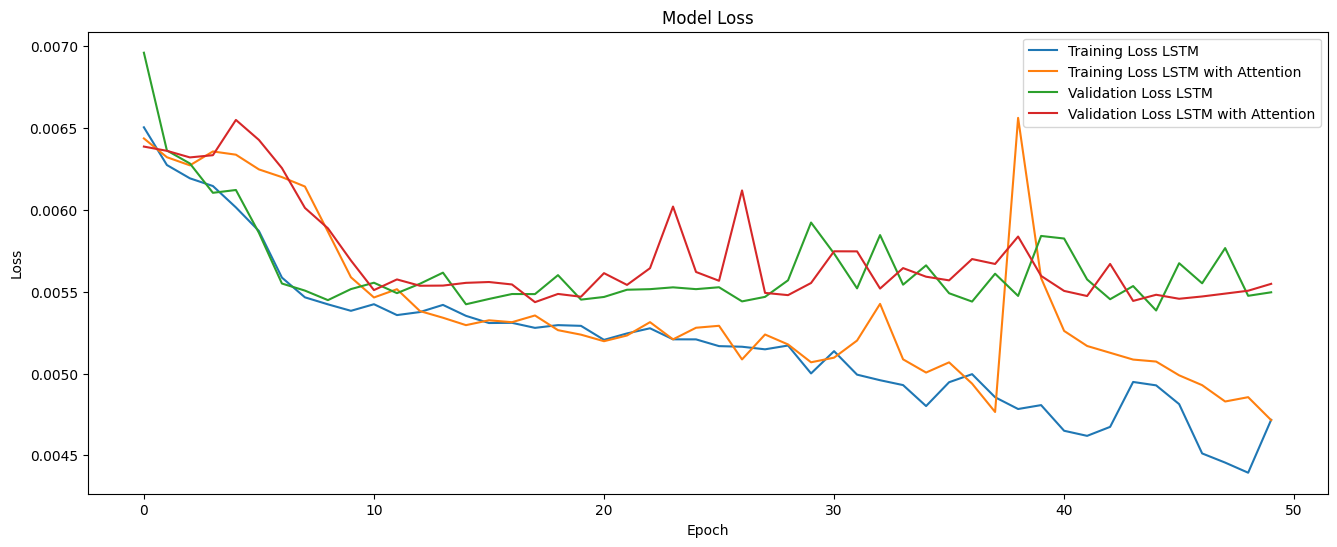

R-squared LSTM: [0.19575047]
MSE LSTM: [0.01051819]
MAE LSTM: [0.05307526]
RMSE LSTM : [0.10255822]
R-squared LSTM with Attention: [0.06035453]
MSE LSTM with Attention: [0.01228893]
MAE LSTM with Attention: [0.05764344]
RMSE LSTM with Attention: [0.11085545]


In [12]:
# Plot hasil pelatihan
plt.figure(figsize=(16, 6))
plt.plot(history_lstm.history['loss'], label='Training Loss LSTM')
plt.plot(history_lstm_attention.history['loss'], label='Training Loss LSTM with Attention')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss LSTM')
plt.plot(history_lstm_attention.history['val_loss'], label='Validation Loss LSTM with Attention')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Menampilkan hasil evaluasi
print(f'R-squared LSTM: {r2_lstm}')
print(f'MSE LSTM: {mse_lstm}')
print(f'MAE LSTM: {mae_lstm}')
print(f'RMSE LSTM : {rmse_lstm}')
print(f'R-squared LSTM with Attention: {r2_lstm_attention}')
print(f'MSE LSTM with Attention: {mse_lstm_attention}')
print(f'MAE LSTM with Attention: {mae_lstm_attention}')
print(f'RMSE LSTM with Attention: {rmse_lstm_attention}')


Nilai prediksi dan nilai asli LSTM Regular

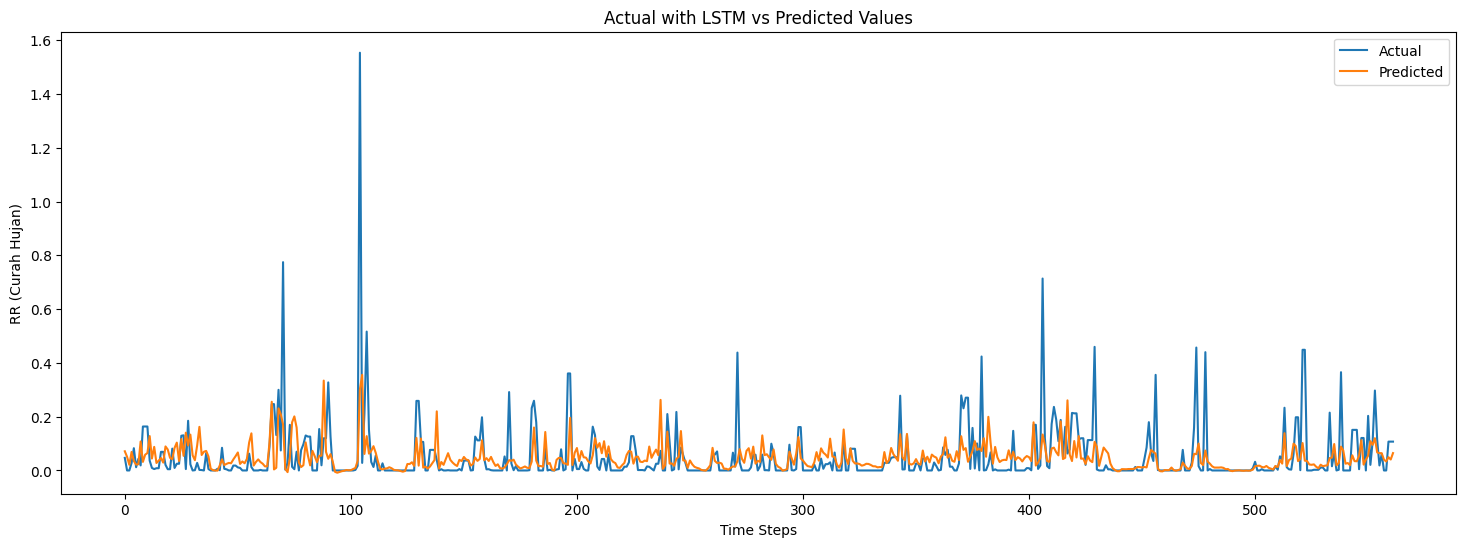

In [13]:
# Plot prediksi vs nilai sebenarnya LSTM Reguler
plt.figure(figsize=(18, 6))
plt.plot(y_test_seq, label='Actual')
plt.plot(y_pred_lstm, label='Predicted')
plt.title('Actual with LSTM vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('RR (Curah Hujan)')
plt.legend()
plt.show()

Nilai prediksi dan nilai asli LSTM Attention

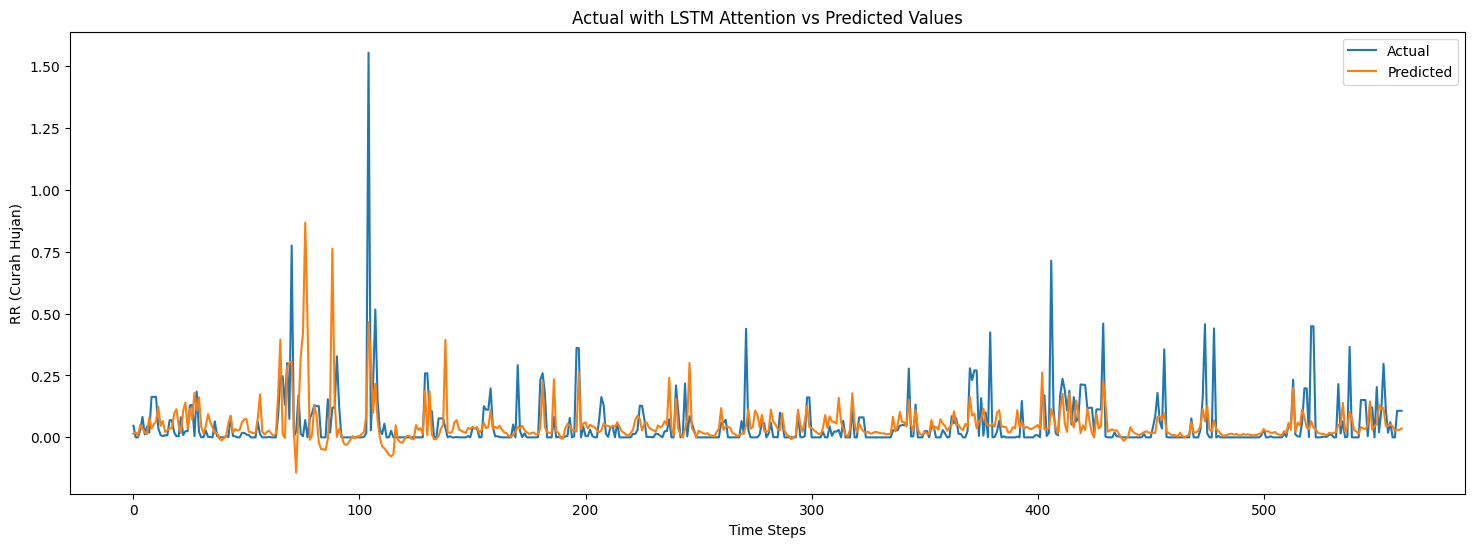

In [14]:
# Plot prediksi vs nilai sebenarnya LSTM Attention

# Mengembalikan ke nilai asli
plt.figure(figsize=(18, 6))
plt.plot(y_test_seq, label='Actual')
plt.plot(y_pred_lstm_attention, label='Predicted')
plt.title('Actual with LSTM Attention vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('RR (Curah Hujan)')
plt.legend()
plt.show()

Save the model

In [76]:
# Simpan model
tf.saved_model.save(model_lstm, 'saved_model_lstm')
tf.saved_model.save(model_lstm_attention, 'saved_model_lstm_attention')

TypeError: this __dict__ descriptor does not support '_DictWrapper' objects

In [ ]:
# Zip model agar mudah di download
!zip -r /content/saved_model_lstm.zip /content/saved_model_lstm
!zip -r /content/saved_model_lstm_attention.zip /content/saved_model_lstm_attention

  adding: content/saved_model_lstm/ (stored 0%)
  adding: content/saved_model_lstm/variables/ (stored 0%)
  adding: content/saved_model_lstm/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: content/saved_model_lstm/variables/variables.index (deflated 64%)
  adding: content/saved_model_lstm/saved_model.pb (deflated 90%)
  adding: content/saved_model_lstm/assets/ (stored 0%)
  adding: content/saved_model_lstm/fingerprint.pb (stored 0%)
  adding: content/saved_model_lstm_attention/ (stored 0%)
  adding: content/saved_model_lstm_attention/variables/ (stored 0%)
  adding: content/saved_model_lstm_attention/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: content/saved_model_lstm_attention/variables/variables.index (deflated 62%)
  adding: content/saved_model_lstm_attention/saved_model.pb (deflated 90%)
  adding: content/saved_model_lstm_attention/assets/ (stored 0%)
  adding: content/saved_model_lstm_attention/fingerprint.pb (stored 0%)
